In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier

In [4]:
train_df = pd.read_csv('results/train_clean.csv', index_col=0)
test_df = pd.read_csv('results/test_clean.csv', index_col=0)
train_df.columns


Index(['originalTitle', 'rating', 'startYear', 'runtimeMinutes', 'numVotes',
       'totalImages', 'totalCredits', 'titleType', 'canHaveEpisodes',
       'numRegions', 'countryOfOrigin', 'genres', 'ratingNum', 'numGenres',
       'criticReviewsRatio', 'awardsAndNominations', 'hasVideos',
       'moreCountriesOfOrigin'],
      dtype='object')

## Classification: titleType

We can only use numerical features with KNN.
We want to use the model to predict title type since we have seen that clusters on the numerical features were able to capture some information regarding this feature.

In [5]:
num_cols = ['startYear', 'runtimeMinutes', 'numVotes', 'totalImages', 'totalCredits', 'numRegions', 'numGenres', 'criticReviewsRatio']
target_feat = 'titleType'

train_X, train_y = train_df[num_cols], train_df[target_feat]
test_X, test_y = test_df[num_cols], test_df[target_feat]


In [6]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance'))
])

In [7]:
scores = cross_val_score(pipeline, train_X, train_y, cv=splitter)

In [8]:
print(f"Accuracy: {round(scores.mean(), 3)} ({round(scores.std(), 3)})")

Accuracy: 0.776 (0.004)


### Hyperparameter tuning

In [10]:
train_X_scaled = StandardScaler().fit_transform(train_X)

In [11]:
%%time

ks= np.arange(1, 500, 5)
param_grid = {
    "clf__n_neighbors": ks,
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "cityblock"]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=splitter,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(train_X, train_y)
clf = grid.best_estimator_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=6, clf__weights=uniform; total time=   0.3s
[C

In [12]:
results = pd.DataFrame(grid.cv_results_)
results['metric and weight'] = results['param_clf__metric'] + ' ' + results['param_clf__weights']

Text(0, 0.5, 'Mean accuracy score')

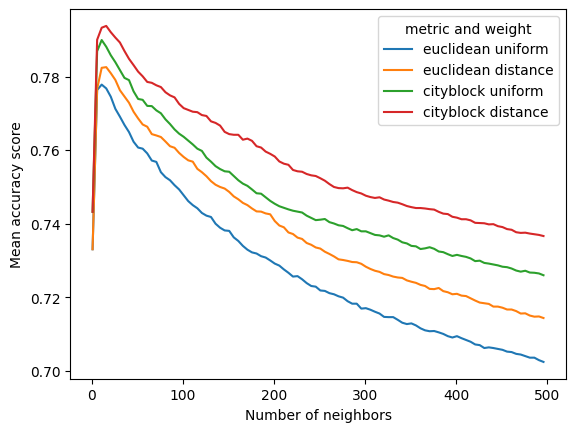

In [13]:
sns.lineplot(
    data=results,
    x='param_clf__n_neighbors',
    y="mean_test_score",
    hue="metric and weight"
)
plt.xlabel("Number of neighbors")
plt.ylabel("Mean accuracy score")

The performance of models using cityblock distance seems to be better and we probably should weight neighbors by distance.

It looks like we can search for the best number of neighbors between 1 and 50.
We will look also to the standar deviation here.

In [14]:
param_grid['clf__n_neighbors'] = np.arange(1, 50)

grid_mini = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    cv=splitter,
                    verbose=2,
                    n_jobs=-1
                    )
grid_mini.fit(train_X, train_y)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[C

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        KNeighborsClassifier(metric='euclidean',
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'clf__metric': ['euclidean', 'cityblock'],
                         'clf__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'clf__weights': ['uniform', 'distance']},
             verbose=2)

In [15]:
results_mini = pd.DataFrame(grid_mini.cv_results_)
results_mini['metric and weight'] = results_mini['param_clf__metric'] + ' ' + results_mini['param_clf__weights']

Text(0, 0.5, 'Mean accuracy score')

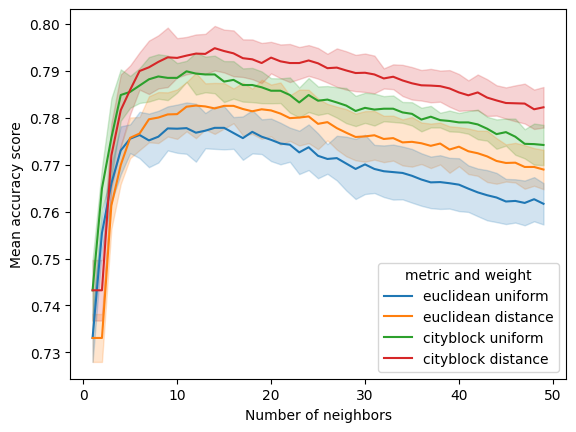

In [16]:
ax = sns.lineplot(
    data=results_mini,
    x='param_clf__n_neighbors',
    y="mean_test_score",
    hue="metric and weight"
)

handles, labels = ax.get_legend_handles_labels()
colors = {
    label: handle.get_color()
    for label, handle in zip(labels, handles)
}

for i, (label, df) in enumerate(results_mini.groupby('metric and weight')):
    x = df['param_clf__n_neighbors'].astype('int')
    mean_score = df['mean_test_score']
    std_score = df['std_test_score']

    ax.fill_between(
        x=x, y1=mean_score + std_score, y2=mean_score - std_score,
        alpha=.2, color=colors[label]
    )

plt.xlabel("Number of neighbors")
plt.ylabel("Mean accuracy score")

In [17]:
grid_mini.best_params_

{'clf__metric': 'cityblock',
 'clf__n_neighbors': 14,
 'clf__weights': 'distance'}

In [18]:
results_mini.sort_values('rank_test_score')[['mean_test_score', 'std_test_score', 'metric and weight', 'param_clf__n_neighbors']].head(10)

,mean_test_score,std_test_score,metric and weight,param_clf__n_neighbors
125,0.794839,0.004746,cityblock distance,14
127,0.794231,0.004561,cityblock distance,15
129,0.793744,0.004885,cityblock distance,16
121,0.793683,0.004082,cityblock distance,12
123,0.793622,0.004266,cityblock distance,13
119,0.793257,0.003979,cityblock distance,11
115,0.792892,0.006337,cityblock distance,9
137,0.792831,0.003366,cityblock distance,20
117,0.792770,0.004207,cityblock distance,10
131,0.792709,0.004012,cityblock distance,17


Considering also the standard deviation, the best number of neighors is probably 20.

### Validation

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(
        metric='cityblock',
        weights='distance',
        n_neighbors=20
    ))
])

In [21]:
y_pred = cross_val_predict(pipeline, train_X, train_y, cv=splitter)

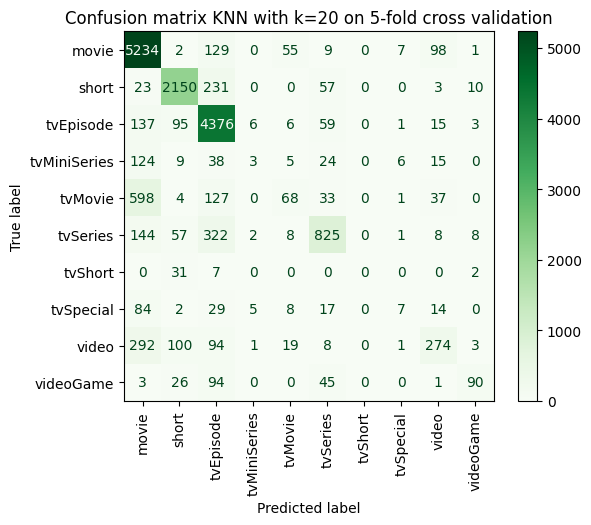

In [22]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=train_y,
                                        xticks_rotation=90,
                                        cmap='Greens')
plt.title("Confusion matrix KNN with k=20 on 5-fold cross validation")
plt.show()

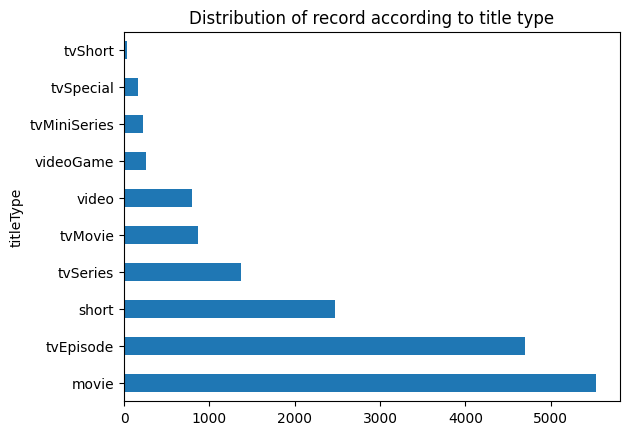

In [23]:
train_df['titleType'].value_counts().plot.barh()
plt.title("Distribution of record according to title type")
plt.show()

### Test

In [24]:
pipeline.fit(train_X, train_y)
y_test_pred = pipeline.predict(test_X)

In [25]:
print(classification_report(y_true=test_y, y_pred=y_test_pred, zero_division=0, digits=3))

              precision    recall  f1-score   support

       movie      0.781     0.943     0.854      1877
       short      0.833     0.862     0.847       766
   tvEpisode      0.798     0.913     0.852      1599
tvMiniSeries      0.400     0.025     0.047        81
     tvMovie      0.456     0.087     0.146       299
    tvSeries      0.712     0.548     0.619       447
     tvShort      0.000     0.000     0.000        16
   tvSpecial      0.071     0.020     0.032        49
       video      0.580     0.304     0.399       250
   videoGame      0.769     0.319     0.451        94

    accuracy                          0.779      5478
   macro avg      0.540     0.402     0.425      5478
weighted avg      0.746     0.779     0.745      5478



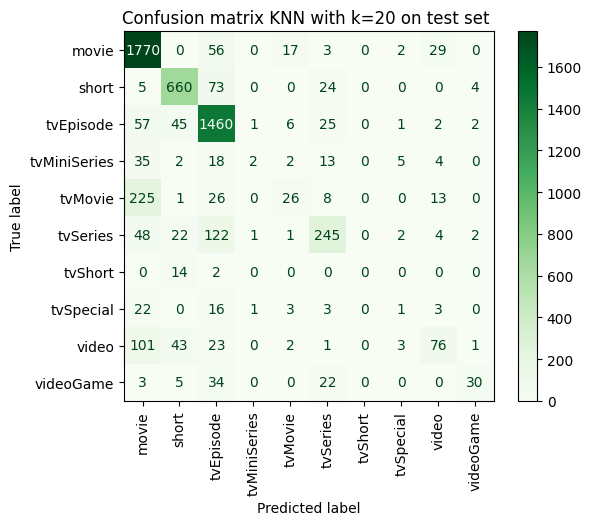

In [26]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_test_pred, y_true=test_y,
                                        xticks_rotation=90,
                                        cmap='Greens')
plt.title("Confusion matrix KNN with k=20 on test set ")
plt.show()

The performance of the model well exceeds that of a dummy classifier.
In particular, the model has little trouble identifying the three most frequent title types (movies, shorts and TV episodes, all have a f1 score higher than .84) and is able to classify correctly tvSeries around half the time.
Looking at the confusion matrix, we can see that tv movies, tv miniseries and videos are most frequently classified as movies while tv shorts are almost always classified as shorts.
TV specials are sometimes classified as tv episodes (especially if shorter) and sometimes as movies (especially if longer).

In [27]:
test_norm = pd.DataFrame(pipeline['scaler'].transform(test_X), columns=num_cols)
test_norm['true'] = test_y
test_norm['knn'] = y_test_pred

In [28]:
tv_special = test_norm['true'] == 'tvSpecial'
test_norm[tv_special].groupby('knn')[num_cols].mean()

,startYear,runtimeMinutes,numVotes,totalImages,totalCredits,numRegions,numGenres,criticReviewsRatio
knn,,,,,,,,
movie,0.332251,0.954740,0.123500,0.025886,-0.120290,-0.461758,-0.623674,-0.516084
tvEpisode,0.115158,0.287504,-0.327586,-0.476036,0.199092,-0.600620,-0.288625,-0.133308
tvMiniSeries,0.923929,0.359145,-0.818490,-0.170960,-0.217394,-0.661879,-1.115991,-0.543183
tvMovie,0.311369,0.359145,-0.832524,-0.897575,-0.219688,-0.661879,-1.115991,-0.543183
tvSeries,1.000499,0.084220,-0.531637,-0.160807,-0.016924,-0.470763,-1.115991,-0.543183
tvSpecial,0.196514,0.359145,-0.445351,-1.091087,-0.030656,-0.661879,-1.115991,-0.543183
video,0.362415,0.583400,-0.658583,-0.897575,-0.847947,-0.661879,-0.313696,-0.543183


In [26]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(train_X, train_y)
dummy_pred = dummy.predict(test_X)


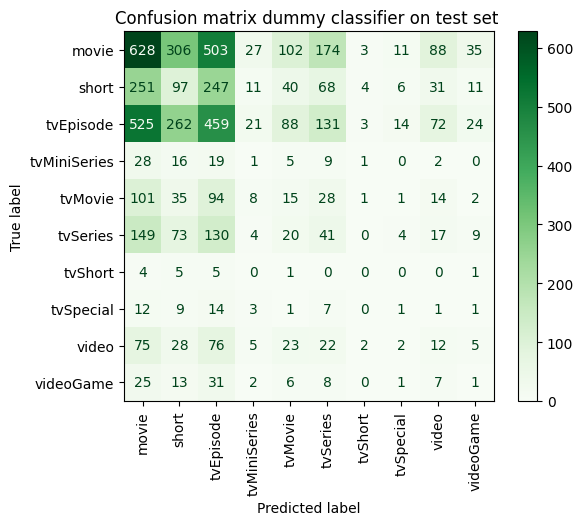

In [32]:
ConfusionMatrixDisplay.from_predictions(y_pred=dummy_pred, y_true=test_y,
                                        xticks_rotation=90,
                                        cmap='Greens')
plt.title("Confusion matrix dummy classifier on test set ")
plt.show()

In [33]:
print("Performance of dummy classifier")
print(classification_report(y_true=test_y, y_pred=dummy_pred, zero_division=0, digits=3))

Performance of dummy classifier
              precision    recall  f1-score   support

       movie      0.349     0.335     0.342      1877
       short      0.115     0.127     0.120       766
   tvEpisode      0.291     0.287     0.289      1599
tvMiniSeries      0.012     0.012     0.012        81
     tvMovie      0.050     0.050     0.050       299
    tvSeries      0.084     0.092     0.088       447
     tvShort      0.000     0.000     0.000        16
   tvSpecial      0.025     0.020     0.022        49
       video      0.049     0.048     0.049       250
   videoGame      0.011     0.011     0.011        94

    accuracy                          0.229      5478
   macro avg      0.099     0.098     0.098      5478
weighted avg      0.233     0.229     0.231      5478



## Classification: rating

We want to use the same features in order to predict the rating class of a record.
We do not expect results comparable to those obtained for the prediction of title type, since we have seen that the records do not cluster by rating in any significant way.

Since we plan to use more sophisticated models for rating classification, we can use the results from knn as a baseline for future models.

In [20]:
target_feat = 'rating'
train_y = train_df[target_feat]
test_y = test_df[target_feat]

In [9]:
%%time

ks= np.arange(1, 500, 5)
param_grid = {
    "clf__n_neighbors": ks,
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "cityblock"]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=splitter,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(train_X, train_y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.1s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   0.2s
[

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        KNeighborsClassifier(metric='euclidean',
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'clf__metric': ['euclidean', 'cityblock'],
                         'clf__n_neighbors': array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106...26,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256,
       261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321,
       326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386,
       391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451,
       456, 461, 466, 471, 476, 481, 486, 491, 496]),
                         'clf__weights': ['uniform', 'distance']},
             verbose=2)

In [10]:
results = pd.DataFrame(grid.cv_results_)
results['metric and weight'] = results['param_clf__metric'] + ' ' + results['param_clf__weights']

Text(0, 0.5, 'Mean accuracy score')

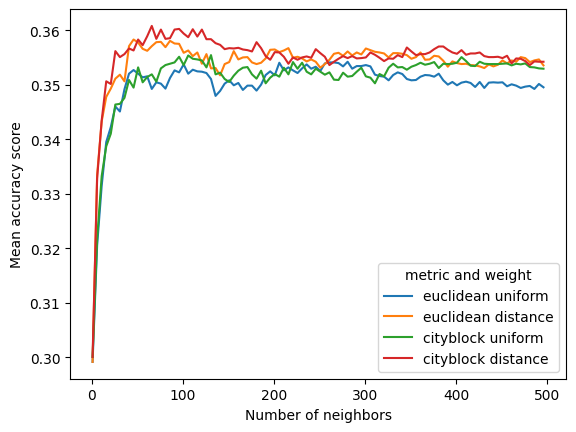

In [11]:
sns.lineplot(
    data=results,
    x='param_clf__n_neighbors',
    y="mean_test_score",
    hue="metric and weight"
)
plt.xlabel("Number of neighbors")
plt.ylabel("Mean accuracy score")

Also in this case it looks like the best strategy would be using cityblock distance with neighbors weighted by distance.
We can refine our search for the best number of neighbors looking to the performance of the model for k between 30 and 130.

In [12]:
param_grid['clf__n_neighbors'] = np.arange(30, 130)

grid_mini = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    cv=splitter,
                    verbose=2,
                    n_jobs=-1
                    )
grid_mini.fit(train_X, train_y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=uniform; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=distance; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=uniform; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=uniform; total time=   0.4s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=distance; total time=   0.4s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=uniform; total time=   0.4s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=distance; total time=   0.4s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=uniform; total time=   0.5s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=distance; total time=   0.3s
[CV] END clf__metric=euclidean, clf__n_neighbors=30, clf__weights=distance; total time

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        KNeighborsClassifier(metric='euclidean',
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'clf__metric': ['euclidean', 'cityblock'],
                         'clf__n_neighbors': array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129]),
                         'clf__weights': ['uniform', 'distance']},
             verbose=2)

In [13]:
results_mini = pd.DataFrame(grid_mini.cv_results_)
results_mini['metric and weight'] = results_mini['param_clf__metric'] + ' ' + results_mini['param_clf__weights']

Text(0, 0.5, 'Mean accuracy score')

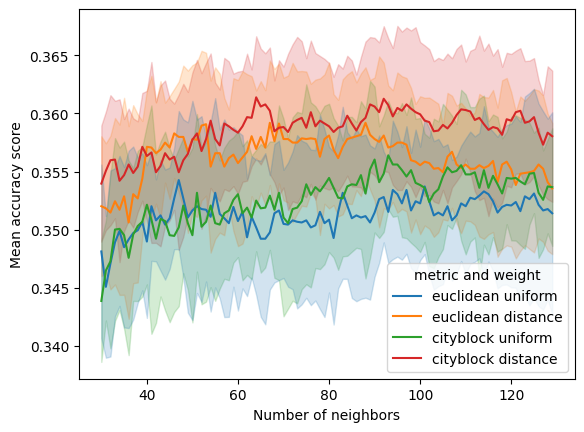

In [14]:
ax = sns.lineplot(
    data=results_mini,
    x='param_clf__n_neighbors',
    y="mean_test_score",
    hue="metric and weight"
)

handles, labels = ax.get_legend_handles_labels()
colors = {
    label: handle.get_color()
    for label, handle in zip(labels, handles)
}

for i, (label, df) in enumerate(results_mini.groupby('metric and weight')):
    x = df['param_clf__n_neighbors'].astype('int')
    mean_score = df['mean_test_score']
    std_score = df['std_test_score']

    ax.fill_between(
        x=x, y1=mean_score + std_score, y2=mean_score - std_score,
        alpha=.2, color=colors[label]
    )

plt.xlabel("Number of neighbors")
plt.ylabel("Mean accuracy score")

In [15]:
grid_mini.best_params_

{'clf__metric': 'cityblock',
 'clf__n_neighbors': 64,
 'clf__weights': 'distance'}

In [16]:
best_model = grid_mini.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 KNeighborsClassifier(metric='cityblock', n_neighbors=64,
                                      weights='distance'))])

### Test

In [17]:
best_model.fit(train_X, train_y)
y_pred = best_model.predict(test_X)

In [22]:
print(classification_report(y_pred=y_pred, y_true=test_y, zero_division=0))

              precision    recall  f1-score   support

      (0, 1]       0.00      0.00      0.00         1
      (1, 2]       0.00      0.00      0.00        20
      (2, 3]       0.00      0.00      0.00        52
      (3, 4]       0.67      0.01      0.03       155
      (4, 5]       0.40      0.10      0.16       384
      (5, 6]       0.31      0.22      0.25       930
      (6, 7]       0.35      0.46      0.40      1522
      (7, 8]       0.41      0.65      0.50      1608
      (8, 9]       0.27      0.07      0.11       690
     (9, 10]       0.75      0.03      0.05       116

    accuracy                           0.37      5478
   macro avg       0.31      0.15      0.15      5478
weighted avg       0.37      0.37      0.33      5478



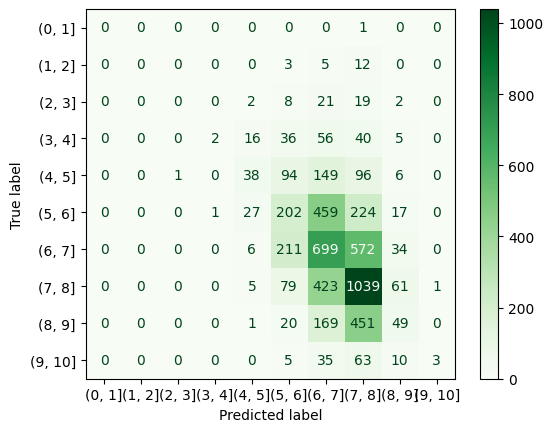

In [24]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=test_y, cmap='Greens')

The performance of the model (although not very good) is systematically better than that of a dummy classifier for all metrics (accuracy: .37 vs accuracy .21 for the dummy model).
In particular, the F1 score of classes with higher support is much higher for the real classifier.

In [28]:
dummy.fit(train_X, train_y)
dummy_pred = dummy.predict(test_X)
print("classification report for dummy classifier")
print(classification_report(y_pred=dummy_pred, y_true=test_y))

classification report for dummy classifier
              precision    recall  f1-score   support

      (0, 1]       0.00      0.00      0.00         1
      (1, 2]       0.00      0.00      0.00        20
      (2, 3]       0.03      0.04      0.03        52
      (3, 4]       0.02      0.02      0.02       155
      (4, 5]       0.08      0.08      0.08       384
      (5, 6]       0.19      0.19      0.19       930
      (6, 7]       0.28      0.28      0.28      1522
      (7, 8]       0.28      0.27      0.28      1608
      (8, 9]       0.12      0.13      0.13       690
     (9, 10]       0.00      0.00      0.00       116

    accuracy                           0.21      5478
   macro avg       0.10      0.10      0.10      5478
weighted avg       0.21      0.21      0.21      5478



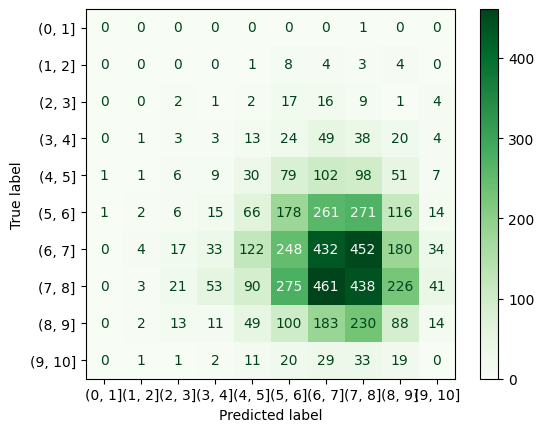

In [30]:
ConfusionMatrixDisplay.from_predictions(y_pred=dummy_pred, y_true=test_y, cmap="Greens")